In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

# Spot Detection

In [78]:
import PLA

PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI_new'
try:
    PPI_save_path.mkdir()
except:
    pass

In [79]:
PPI_names = ['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR', 'Mcl-1 & BAK']

imgs_spots = []
imgs_wth = []
s = []
imgs = []

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path)
    for PPI_pair in PPI_names: 
        img_spot, img_wth, spots_filtered, img = pla_detect.detect_spot(PPI_pair, thres=0.08)
        # imgs_spots.append(img_spot)
        # imgs_wth.append(img_wth)
        # s.append(spots_filtered)
        # imgs.append(img)
        
    # Save PPI dict
    name = '_'.join(row[1:3])+'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)

    

Reading image TEAD1 & YAP1
Processing image TEAD1 & YAP1
(array([0, 1], dtype=uint8), array([29489243,   156709], dtype=int64))
Reading image CylinE & CDK2
Processing image CylinE & CDK2
(array([0, 1], dtype=uint8), array([29539948,   106004], dtype=int64))
Reading image P-ERK & c-MYC
Processing image P-ERK & c-MYC
(array([0, 1], dtype=uint8), array([29452577,   193375], dtype=int64))
Reading image p-AKT & mTOR
Processing image p-AKT & mTOR
(array([0, 1], dtype=uint8), array([29587263,    58689], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([29625170,    20782], dtype=int64))
File exist. Deleted
Reading image TEAD1 & YAP1
Processing image TEAD1 & YAP1
(array([0, 1], dtype=uint8), array([29476201,   124999], dtype=int64))
Reading image CylinE & CDK2
Processing image CylinE & CDK2
(array([0, 1], dtype=uint8), array([29532815,    68385], dtype=int64))
Reading image P-ERK & c-MYC
Processing image P-ERK & c-MYC
(array([0, 1], dtype=

In [80]:
# idx = 3
# img_spot = imgs_spots[idx]
# img_wth = imgs_wth[idx]
# img = imgs[idx]

In [81]:
# import napari

# viewer = napari.view_image(img)
# viewer.add_image(img_spot, contrast_limits=[0,1])

# Extract per cell PPI count

In [82]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [83]:
mask_filt_dir = data_dir / 'OCT Cell Culture' / 'Whole' / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI_new'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [84]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# Plot stats

In [99]:
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI_new'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'FW1' in path:
        continue
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)

In [100]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']


In [101]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)

In [102]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [103]:
# Filter out by maximum number of counts per cell
min_count = 20
max_count = 70

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

,Count_cell,Count_nuclei,Count_cyto
count,633.000000,633.000000,633.000000
mean,53.571880,29.456556,24.115324
std,27.221227,16.033542,18.126951
min,21.000000,0.000000,1.000000
25%,32.000000,19.000000,11.000000
50%,46.000000,26.000000,18.000000
75%,68.000000,38.000000,33.000000
max,160.000000,107.000000,111.000000


In [104]:
df_all = df_all[df_all['Count_cyto']>=0]

In [105]:
df_all

,Condition,FOV,PPI,Id,Count_cell,Count_nuclei,Count_cyto
1,HCC827Ctrl,FW2,CylinE & CDK2,42,15,8,7
2,HCC827Ctrl,FW2,CylinE & CDK2,45,1,0,1
3,HCC827Ctrl,FW2,CylinE & CDK2,46,4,2,2
4,HCC827Ctrl,FW2,CylinE & CDK2,47,4,2,2
6,HCC827Ctrl,FW2,CylinE & CDK2,49,8,6,2
...,...,...,...,...,...,...,...
4011,HCC827Osim,FW2,p-AKT & mTOR,515,1,1,0
4012,HCC827Osim,FW2,p-AKT & mTOR,519,4,4,0
4013,HCC827Osim,FW2,p-AKT & mTOR,521,23,2,21
4015,HCC827Osim,FW2,p-AKT & mTOR,525,4,3,1


## Plots

In [106]:
from statannotations.Annotator import Annotator


In [107]:
def plot(plotting):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(7,4))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

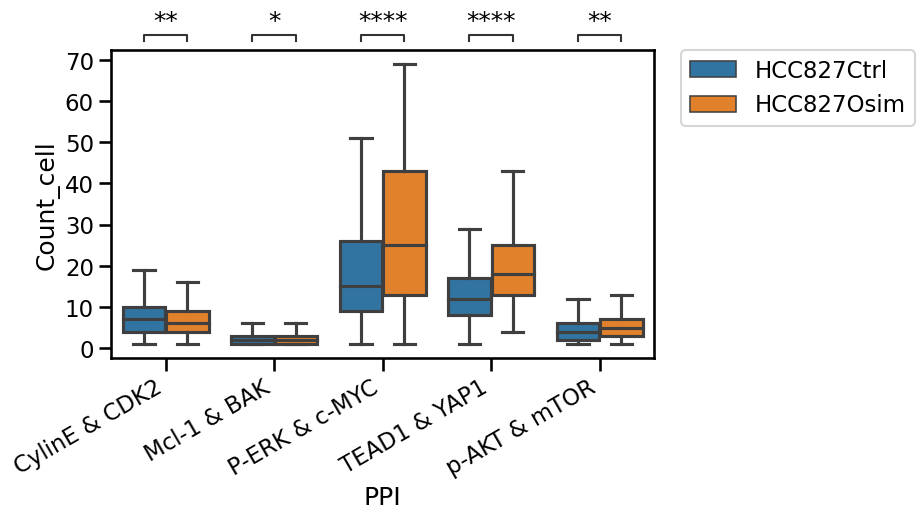

In [108]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

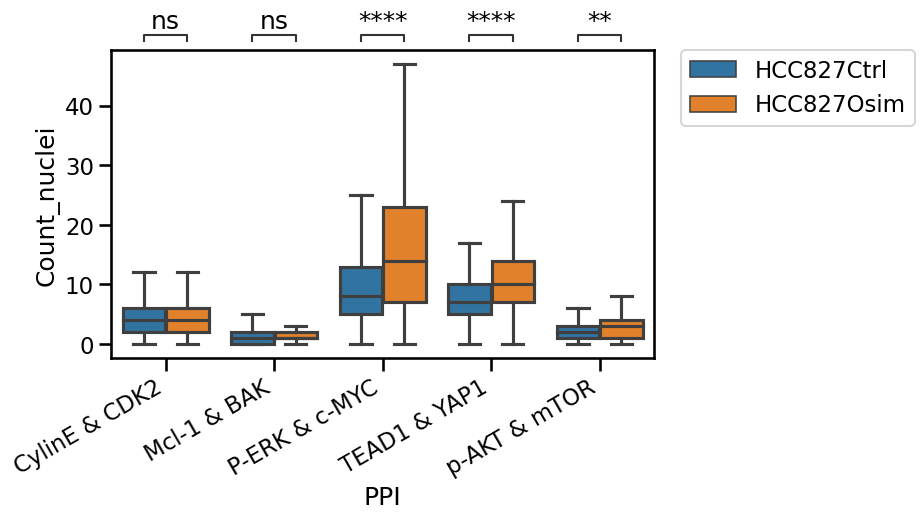

In [109]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

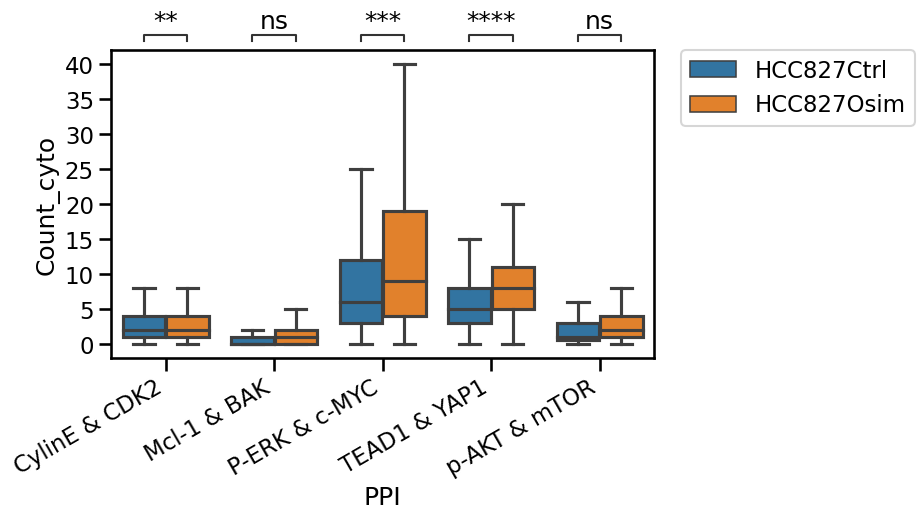

In [110]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.148e-05 U_stat=3.357e+04
CylinE & CDK2_Count_nuclei vs. CylinE & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:2.649e-18 U_stat=7.695e+04
P-ERK & c-MYC_Count_nuclei vs. P-ERK & c-MYC_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:2.365e-04 U_stat=6.531e+04
TEAD1 & YAP1_Count_nuclei vs. TEAD1 & YAP1_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:5.644e-09 U_stat=7.106e+04
p-AKT & mTOR_Count_nuclei vs. p-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.167e-03 U_stat=5.689e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 

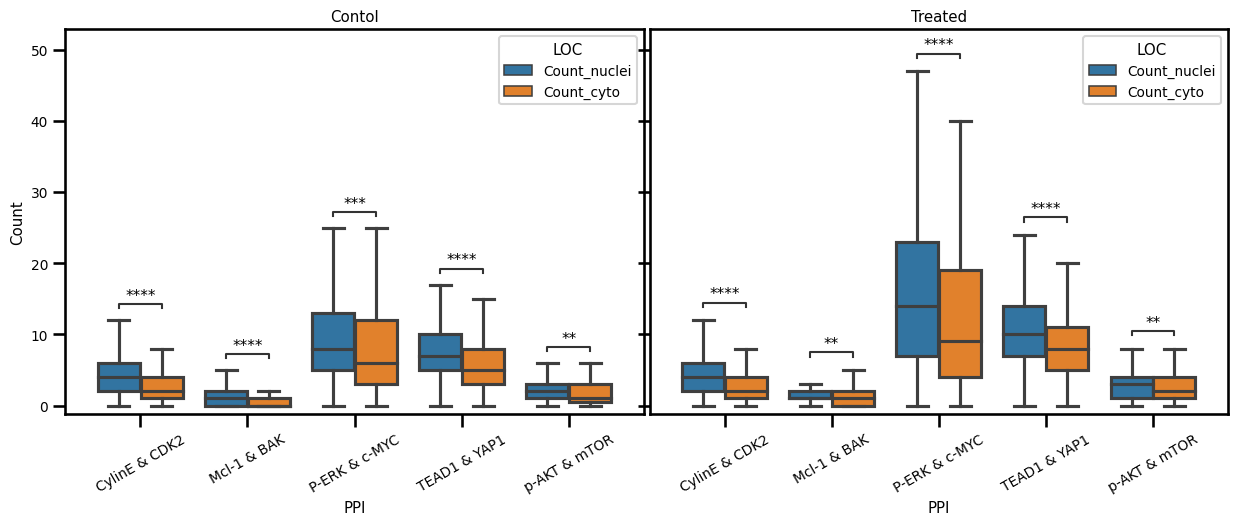

In [111]:
# Boxplot per loc
df_melt = df_all.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'HCC827Ctrl']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == 'HCC827Osim']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)